# Creating NLP Word Embeddings with PyTorch

In [1]:
# https://stackoverflow.com/questions/50747947/embedding-in-pytorch
# https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

from IPython.display import clear_output
import time

In [3]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
#!pip install wikipedia
import wikipedia

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

import mpld3
mpld3.enable_notebook()
#!pip install --user "git+https://github.com/javadba/mpld3@display_fix"

# Web-Scraper collects corpus from Wikipedia in real time

The `Wikipedia_Crawler` class uses the `wikipedia` module to load a _corpus_ in real time.<br>

In [7]:
from nlp_labs.my_nlp_classes import Wikipedia_Crawler

First, we have to set the desired language of the searches. 

In [8]:
wikipedia.set_lang('pt')

It will search specific wikis from the input query and downloads its content.
- `query_list` is the list of query text to look for in Wikipedia
- `max_results` is the maximum number of pages to load per query expression in the `query_list`
- `max_v` will be used later to limit the vocabulary size of our custom dictionary
- `skip_top` is the number of most frequent words (descending order) to be discard.

In [9]:
query_list  = ['Rainha','Rei','Mulher','Homem','Brasil','Japão','Família','Tempo','Calendário'] #  
max_results = 3
max_V       = 3000
skip_top    = 0
max_len_sentence = 100

Next cell, we instantiate the crawler with its basic query parameters.

In [10]:
wiki_crawler = Wikipedia_Crawler(query_list=query_list,max_results_per_query=max_results)

To find the desired wiki pages, we call for `query_wiki`. <br>
The methods `get_wiki_sentences` downloads and tokenizes the sentences of the pages. <br> 
Then, `get_all_tokens` lists all unique tokens (words) in the data. Tokenization is performed in the process. <br>
Finally, `count_vocabulary` counts the absolute frequency of each token. Tokenization is performed in the process.

In [11]:
wiki_crawler.query_wiki()
wiki_crawler.get_wiki_sentences()
wiki_crawler.get_all_tokens()
wiki_crawler.count_vocabulary()

Using all the tokens may be prohibitive. Thus, it is necessary to limit the vocabulary. <br>
- `generate_vocabulary` will create `word2idx` and `idx2word` dictionaries 
- - dictionaries will be limited with `max_V` words ($+ 3$ tags)
- - note that `skip_top` most frequent words will be discarded
- `encode_all_sentence` will encode sentences of words into sequences (lists) of corresponding indexes
- - encoded sentences will have additional `"<START>"` and `"<END>"` tokens
- - words out of vocabulary will be coded with index of `"<OOV>"` tag
- - encoded senteces will be truncated with `max_len_sentence` actual words ($+ 2$ start/end tags)
- - encoded senteces padded by default, unless `pad_sentences` is set to `False`

In [12]:
wiki_crawler.generate_vocabulary(max_len_vocabulary=max_V, skip_top_words=skip_top)
wiki_crawler.encode_all_sentence(max_len_sentence=max_len_sentence, pad_sentences=True) # pad_sentences is True by default

Check where did the corpus came from and other results.

In [13]:
S = len(wiki_crawler.sentences)           
T = len(wiki_crawler.coded_sentences[0]) # max_len_sentence + 2
V = len(wiki_crawler.word2idx)           # max_V + 2

print(f' Corpus derived from the following wiki pages: \n ---- {wiki_crawler.titles_list}')
print(f' Number of sentences: ------ {S}')
print(f' Max. words in sentence: --- {T-2}')
print(f' Vocabulary Size: ---------- {V}')

 Corpus derived from the following wiki pages: 
 ---- ['Rainha', 'A Rainha', 'Salve-rainha', 'Rei', 'O Rei Leão', 'Rei (xadrez)', 'Mulher', 'Mulher-Gato', 'Mulher-Maravilha', 'Homem', 'Homem-Aranha', 'O Homem Elefante', 'Brasil', 'Município (Brasil)', 'Presidente do Brasil', 'Japão', 'História do Japão', 'Culinária do Japão', 'Família', 'Família Jackson', 'Família Gracie', 'Tempo', 'O Tempo Não Para', 'Tempo verbal', 'Calendário', 'Calendário gregoriano', 'Calendário chinês']
 Number of sentences: ------ 4079
 Max. words in sentence: --- 100
 Vocabulary Size: ---------- 3003


Here is how we can check the generated sentences.  

In [14]:
num_sentence = 5

real_sentence    = wiki_crawler.sentences[num_sentence]
encoded_sentece  = wiki_crawler.coded_sentences[num_sentence]
decoded_sentence = wiki_crawler.decode_one_sentence(encoded_sentece)

print(f' Real Text sentence: \n    {real_sentence}', end=2*'\n')
print(f' Encoded Sentence: \n    {encoded_sentece}', end=2*'\n')
print(f' Decoded Sentence: \n    '+' '.join(decoded_sentence))

 Real Text sentence: 
    entre os reis davi de judá e israel, não é mencionado uma única rainha reinante; apesar de atália, embora a bíblia se refira negativamente como uma usurpadora.

 Encoded Sentence: 
    [1, 35, 15, 1577, 0, 3, 0, 6, 0, 27, 18, 0, 16, 567, 120, 611, 228, 3, 0, 123, 4, 949, 12, 2247, 0, 19, 16, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 Decoded Sentence: 
    <START> entre os reis de e não é uma única rainha reinante apesar de embora a bíblia se refira como uma <END>


Next, we can see how to use the dictionary directly to convert `wor2idx` or `idx2word`.

In [15]:
word = 'mulher'
idx = 9
print(f' Word "{word}" corresponds to index {wiki_crawler.word2idx[word]}')
print(f' Index {idx} corresponds to word "{wiki_crawler.idx2word[idx]}"')

 Word "mulher" corresponds to index 37
 Index 9 corresponds to word "que"


# Embeddings in PyTorch

Next, we'll see how to use the ``Embedding`` layer of Torch. <br>
It converts categorical data with $V$ classes to dense vectors with $N_d$ dimensions. <br>
Suppose $c\in{F_2^V}$ is a one-hot encoded vector. <br>
An embedding is a mapping $e:F_2^V\to R^{N_d}$ (sparse vector, one-hot encoded, to dense real vector).

In [16]:
Nd = 2                  # Number of Dimensions of the Dense embedding
e = nn.Embedding(V,Nd)  # (vocab_size, num_of_dimensions_of_embedding)

Let's first convert the coded sentences to Torch Tensors.

In [17]:
coded_sentences = torch.LongTensor(wiki_crawler.coded_sentences).reshape(-1,T).T
print(f' V x S : {coded_sentences.shape} (vocab. size x num. of sentences)')
print(f' Tensors of type {coded_sentences.dtype}')
print(' All encoded sentences as tensors (each column is a sentence):')
print(coded_sentences)

 V x S : torch.Size([102, 4079]) (vocab. size x num. of sentences)
 Tensors of type torch.int64
 All encoded sentences as tensors (each column is a sentence):
tensor([[   1,    1,    1,  ...,    1,    1,    1],
        [ 120,  120,   78,  ...,   20,  620, 2566],
        [ 516,  611,   14,  ...,  255,    0,  297],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]])


Let's select, for example, the first sentence, as the varible $c$.

In [18]:
c = coded_sentences[:,0]
print(c.shape,c,sep='\n')

torch.Size([102])
tensor([   1,  120,  516, 1182,    4,    0,   18,    5,  728,    3,   52, 1575,
           0,    0,   31,  787,   19,    4,  120, 2665,  131, 2246,  788,    7,
         211, 1023,   29, 1183,   31,  882,    7,   52,   50,   82,  288,    3,
         120,  883,  131,  120,    0,   10, 1758,    2,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])


Next, we convert the sentence from sequences of one-hot-encoded words to its embedding vector.<br>
When printing the corresponding sequence, we see that:
- each index (one-hot-encoded word) is converted into a real row-vector of $N_d$ dimensions
- the initialized embedding vectors are just random values.

In [19]:
e_seq = e(c)
print(e_seq.shape,e_seq[:10,:],'... and more words (truncated in the 10-th word).',sep='\n') 

torch.Size([102, 2])
tensor([[-0.6350,  0.4096],
        [-0.3341, -0.3527],
        [ 0.8590, -1.3855],
        [-0.9808, -0.8642],
        [ 1.2915, -0.6614],
        [-0.2307,  1.2365],
        [ 0.6716,  0.0221],
        [ 0.3161,  0.6829],
        [ 0.2401, -0.7691],
        [ 1.9052, -0.8429]], grad_fn=<SliceBackward>)
... and more words (truncated in the 10-th word).


Choose a word to check its embedding vector.

In [20]:
word    = 'rainha'

idx     = wiki_crawler.word2idx[word] # uses dictionary to map word to index
emb_vec = e(torch.LongTensor([idx]))  # uses torch embedding to map index to dense Nd-vector

print(f' Word "{word}" corresponds to index {idx}')
print(f' Index {idx} maps to embedding vector "{emb_vec.detach().numpy().reshape(-1).tolist()}"')

 Word "rainha" corresponds to index 120
 Index 120 maps to embedding vector "[-0.3340754210948944, -0.35269027948379517]"


In [21]:
W1 = e.weight.data
W1.shape, W1.dtype, W1

(torch.Size([3003, 2]),
 torch.float32,
 tensor([[-0.2307,  1.2365],
         [-0.6350,  0.4096],
         [ 0.9973,  0.3776],
         ...,
         [-0.7678,  0.9854],
         [-0.3680, -0.2005],
         [ 0.3326,  0.2633]]))

# Training the Embeddings with Language Model

## Continuous Bag-of-Words (CBOW)

context vs target

In [22]:
print(c)

tensor([   1,  120,  516, 1182,    4,    0,   18,    5,  728,    3,   52, 1575,
           0,    0,   31,  787,   19,    4,  120, 2665,  131, 2246,  788,    7,
         211, 1023,   29, 1183,   31,  882,    7,   52,   50,   82,  288,    3,
         120,  883,  131,  120,    0,   10, 1758,    2,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])


In [23]:
context_size = 2
end_position = (c==2).nonzero().item()

samples_to_print = np.concatenate((np.arange(1,5),np.arange(end_position-5,end_position)),axis=0)
for pos in samples_to_print: # range(1,end_position):
    
    middle_word   = c[pos]
    
    '''if middle_word==wiki_crawler.word2idx['<END>']:
        break'''
    
    left_start = max(pos-context_size,1)
    right_end  = min(pos+1+context_size,end_position)
    
    
    if pos - left_start < context_size:                # first words position
        right_end += context_size-(pos-left_start)     # --> increse right_context size
    elif right_end-(pos+1) < context_size:             # last words position
        left_start -= context_size-(right_end-(pos+1)) # --> increase left_context size
            
    left_context  = c[left_start:pos]
    right_context = c[pos+1:right_end]
    
    context       = torch.cat((left_context,right_context),dim=0)
    
    print(f' Left context: {left_context.tolist()}, Middle word: {middle_word.tolist()}, right context {right_context.tolist()}')
    print(f' Full context: {context.tolist()}')
    
    context_decoded     = wiki_crawler.decode_one_sentence(context.tolist())
    middle_word_decoded = wiki_crawler.decode_one_sentence([middle_word.tolist()])
    print(f' Words in context of {middle_word_decoded}: {context_decoded}')
    print('')

 Left context: [], Middle word: 120, right context [516, 1182, 4, 0]
 Full context: [516, 1182, 4, 0]
 Words in context of ['rainha']: ['antigo', 'ray', 'a']

 Left context: [120], Middle word: 516, right context [1182, 4, 0]
 Full context: [120, 1182, 4, 0]
 Words in context of ['antigo']: ['rainha', 'ray', 'a']

 Left context: [120, 516], Middle word: 1182, right context [4, 0]
 Full context: [120, 516, 4, 0]
 Words in context of ['ray']: ['rainha', 'antigo', 'a']

 Left context: [516, 1182], Middle word: 4, right context [0, 18]
 Full context: [516, 1182, 0, 18]
 Words in context of ['a']: ['antigo', 'ray', 'é']

 Left context: [120, 883], Middle word: 131, right context [120, 0]
 Full context: [120, 883, 120, 0]
 Words in context of ['exemplo']: ['rainha', 'consorte', 'rainha']

 Left context: [883, 131], Middle word: 120, right context [0, 10]
 Full context: [883, 131, 0, 10]
 Words in context of ['rainha']: ['consorte', 'exemplo', 'da']

 Left context: [131, 120], Middle word: 0,

In [24]:
def get_context(coded_sentence, context_size):
    
    end_position = (c==2).nonzero().item()
    target_context = []
    for pos in range(1,end_position):
        middle_word   = coded_sentence[pos]

        left_start = max(pos-context_size,1)
        right_end  = min(pos+1+context_size,end_position)

        if pos - left_start < context_size:                # first words position
            right_end += context_size-(pos-left_start)     # --> increse right_context size
        elif right_end-(pos+1) < context_size:             # last words position
            left_start -= context_size-(right_end-(pos+1)) # --> increase left_context size

        left_context  = c[left_start:pos]
        right_context = c[pos+1:right_end]
        
        context       = torch.cat((left_context,right_context),dim=0)
        
        target_context.append((middle_word.view((-1)),context))
    return target_context

In [25]:
class Language_Model_w2v(nn.Module):
    
    def __init__(self, vocab_size, num_of_dimensions_of_embedding, context_size):
        super(Language_Model_w2v, self).__init__()
        self.V  = vocab_size
        self.N  = num_of_dimensions_of_embedding 
        self.cs = context_size
        
        self.e  = nn.Embedding(self.V, self.N)
        '''
        self.W1 = nn.Linear(2*self.cs*self.N,128)
        self.W2 = nn.Linear(128, self.V)
        '''
        # self.layers = nn.Sequential(*[self.e, self.W1, self.W2,self.LogSoftMax])
        
        self.Winv = nn.Linear(self.N, self.V)
        self.LogSoftMax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):               # x is 2*cs x 1
        x = self.e(x)
        x = x.sum(dim=0).view(1,-1)
        x = self.Winv(x)
        x = self.LogSoftMax(x)
        
        return x
        ''' 
        x = self.e(x).view((1,-1))     # e(x) 2*cs x N
        x = self.W1(x)
        x = F.relu(x)
        x = self.W2(x)
        log_probs = self.LogSoftMax(x)
        return log_probs
        '''

In [26]:
max_epochs = 5
print_iters = 50
cs = 3
Nd = 10
losses    = []
criterion = nn.NLLLoss()
model     = Language_Model_w2v(V, num_of_dimensions_of_embedding=Nd, context_size=cs)
optimizer = optim.Adam(model.parameters(), lr=1e-3) # optim.SGD(model.parameters(),lr=1e-3) # 

In [27]:
model

Language_Model_w2v(
  (e): Embedding(3003, 10)
  (Winv): Linear(in_features=10, out_features=3003, bias=True)
  (LogSoftMax): LogSoftmax()
)

In [30]:
for epoch in range(max_epochs):
    
    cnt = 0
    total_loss = 0
    
    coded_sentences = coded_sentences[:,np.random.permutation(S)]
    
    for n in range(S):
        
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words into integer indices and wrap them in tensors)
        c = coded_sentences[:,n]
        
        pos_cnt = 0
        for target, context in get_context(c, cs):
            pos_cnt += 1
            if len(context)<2*cs:
                continue
            
            # Step 2. Recall that torch *accumulates* gradients. 
            # Before passing in a new instance, you need to zero out the gradients from the oldinstance
            model.zero_grad()
            
            # Step 3. Run the forward pass, getting log probabilities over next words
            log_probs = model(context)  
            
            # Step 4. Compute your loss function. 
            # (Again, Torch wants the target word wrapped in a tensor)
            loss = criterion(log_probs, target)

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()

            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()/T/S
            
        cnt+=1
        if n%print_iters==1:
            print(f'epoch {epoch} sentence {n}/{S} loss: {total_loss:.5f}')
    print(f'loss: {total_loss:.6f}')
    losses.append(total_loss)
    
    time.sleep(1.5)
    clear_output()
#print(losses)  # The loss decreased every iteration over the training data!

In [31]:
pos_cnt

81

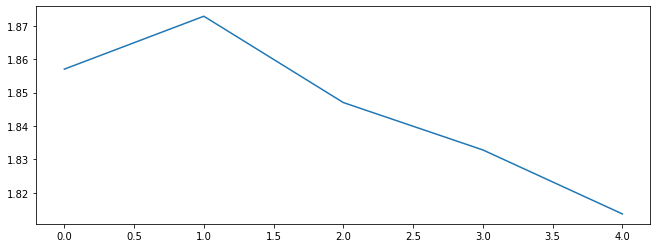

In [32]:
plt.figure(figsize=(11,4))

plt.plot(losses)

In [33]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape) # param.data

e.weight torch.Size([3003, 10])
Winv.weight torch.Size([3003, 10])
Winv.bias torch.Size([3003])


In [34]:
Embedding = model.e.weight.data
Embedding.shape, Embedding

(torch.Size([3003, 10]),
 tensor([[ 2.9594e-01, -6.8543e-02, -1.6310e-01,  ..., -2.2459e-01,
           1.7763e-01,  7.1652e-01],
         [ 1.2123e-01,  1.7437e-01, -9.9919e-02,  ..., -1.6410e+00,
          -9.3114e-01, -2.7260e-01],
         [-1.7299e+00, -1.7535e-01, -3.1855e-01,  ...,  3.4555e-01,
           1.9645e-01,  1.5670e-01],
         ...,
         [-2.5660e+00,  1.7125e+00,  1.0468e+00,  ..., -1.3669e-03,
           8.5296e-02,  5.5529e-01],
         [-5.5270e-01, -1.3120e-01, -1.7963e+00,  ...,  3.4877e-01,
          -8.5716e-01, -2.8250e-01],
         [-1.3551e+00,  5.7612e-01,  3.7605e-01,  ...,  1.5092e+00,
           2.2110e+00, -2.8951e-01]]))

In [35]:
def word_analogy(pos_neg_1=('king','man'),pos_neg_2=('queen','woman'), n_closest = 4):
    king_w,    man_w = pos_neg_1
    queen_w, woman_w = pos_neg_2
    
    for w in (king_w,man_w,woman_w):
        if w not in wiki_crawler.word2idx:
            raise Exception(f'sorry, word "{w}" not in dictionary.')
    
    print(f'Expected: {king_w} - {man_w} = {queen_w} - {woman_w}')
    
    king   = wiki_crawler.word2idx[king_w]
    man    = wiki_crawler.word2idx[man_w]
    woman  = wiki_crawler.word2idx[woman_w]
    
    vec = (Embedding[king] - Embedding[man] + Embedding[woman]).view(1,-1) # Embedding[queen]
    distances = pairwise_distances(vec.reshape(1, -1), Embedding, metric='cosine').reshape(V)
    
    idx = distances.argsort()[:n_closest+3] 
    idx = [x for x in idx if x not in set([man,king,woman])]
    queen_estimated = wiki_crawler.idx2word[idx[0]]
    
    print(f'Got:      {king_w} - {man_w} = {queen_estimated} - {woman_w}')
    
    print(f'Closest {len(idx)} words:')
    for i in idx:
        print(f'{wiki_crawler.idx2word[i]}')

In [36]:
word_analogy(pos_neg_1=('rei','homem'),pos_neg_2=('rainha','mulher'), n_closest = 4)

Expected: rei - homem = rainha - mulher
Got:      rei - homem = espaço - mulher
Closest 6 words:
espaço
fundamental
restauração
dada
simples
termos


In [37]:
word_analogy(pos_neg_1=('rei','príncipe'),pos_neg_2=('rainha','princesa'), n_closest = 4)

Expected: rei - príncipe = rainha - princesa
Got:      rei - príncipe = observou - princesa
Closest 7 words:
observou
princípio
superior
feira
nuclear
personagem
circunstâncias


In [38]:
word_analogy(pos_neg_1=('homem','mulher'),pos_neg_2=('ele','ela'), n_closest = 4)

Expected: homem - mulher = ele - ela
Got:      homem - mulher = trabalhando - ela
Closest 6 words:
trabalhando
vale
chinês
seguindo
estando
gato


In [39]:
word_analogy(pos_neg_1=('homem','mulher'),pos_neg_2=('marido','esposa'), n_closest = 4)

Expected: homem - mulher = marido - esposa
Got:      homem - mulher = trabalhando - esposa
Closest 6 words:
trabalhando
pertencente
olímpicos
diretor
objetivo
esforço


In [44]:
word_analogy(pos_neg_1=('brasil','brasileiro'),pos_neg_2=('japão','japonês'), n_closest = 4)

Expected: brasil - brasileiro = japão - japonês
Got:      brasil - brasileiro = filme - japonês
Closest 7 words:
filme
papel
jogo
esporte
projeto
afirmou
perde
